# Method Selection

Below are the finalized (at the moment) methods for estimating the validation paramters. Descriptions for each will be supplied, along with code that will be able to generalize for any station.

In [1]:
# Import functions for graphing and methods (also includes some libraries needed for data analysis)
from graphing_funcs import *
from method_funcs import *

%matplotlib inline

from matplotlib.colors import ListedColormap

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13
plt.rcParams['figure.dpi'] = 300

# Import libraries for sql connection
import mysql.connector
import pickle
import warnings

warnings.filterwarnings('ignore')

# Load credentials for login (hidden and not added to repo)
with open("login_cred.pkl", "rb") as fp:
    config = pickle.load(fp)
    
cnx = mysql.connector.connect(**config) # connection point

## Overall Temperature Bounds
The final method chosen for estimating overall min/max temperature bounds is **daily temperature estimation** based on the following:
- Filter the temperature values based on quantiles to eliminate extreme outliers. This is applied per day (across a row of temp readings) - returns a single value for the min/max on that given day.
- Create two new columns (month_day and year) which correspond to a unique MM-DD and YYYY combination.
- Group the data based on month_day to get all observations for a single day, across all years. For each of these groups, take min and max across all years to get estimate min/max for that day. Repeat for all 366 days (includes leap year).
- We now have an estimate for the daily min/max for each day. Add a threshold of $\pm$ 15 degrees to the corresponding min/max estimates. *We also looked at using standard deviation for each day, but noticed it would cut off valid values. Adding a threshold held better and did not cut off valid readings.*
- **As a quality assurance check, an IQR method is applied to find the monthly min/max for temperatures since they have more data and can filter more values without reducing real readings (only remove outliers). These values are then used to replace daily estimates that violate the monthly temperature estimates (see function temp_bounds_modified for details).**

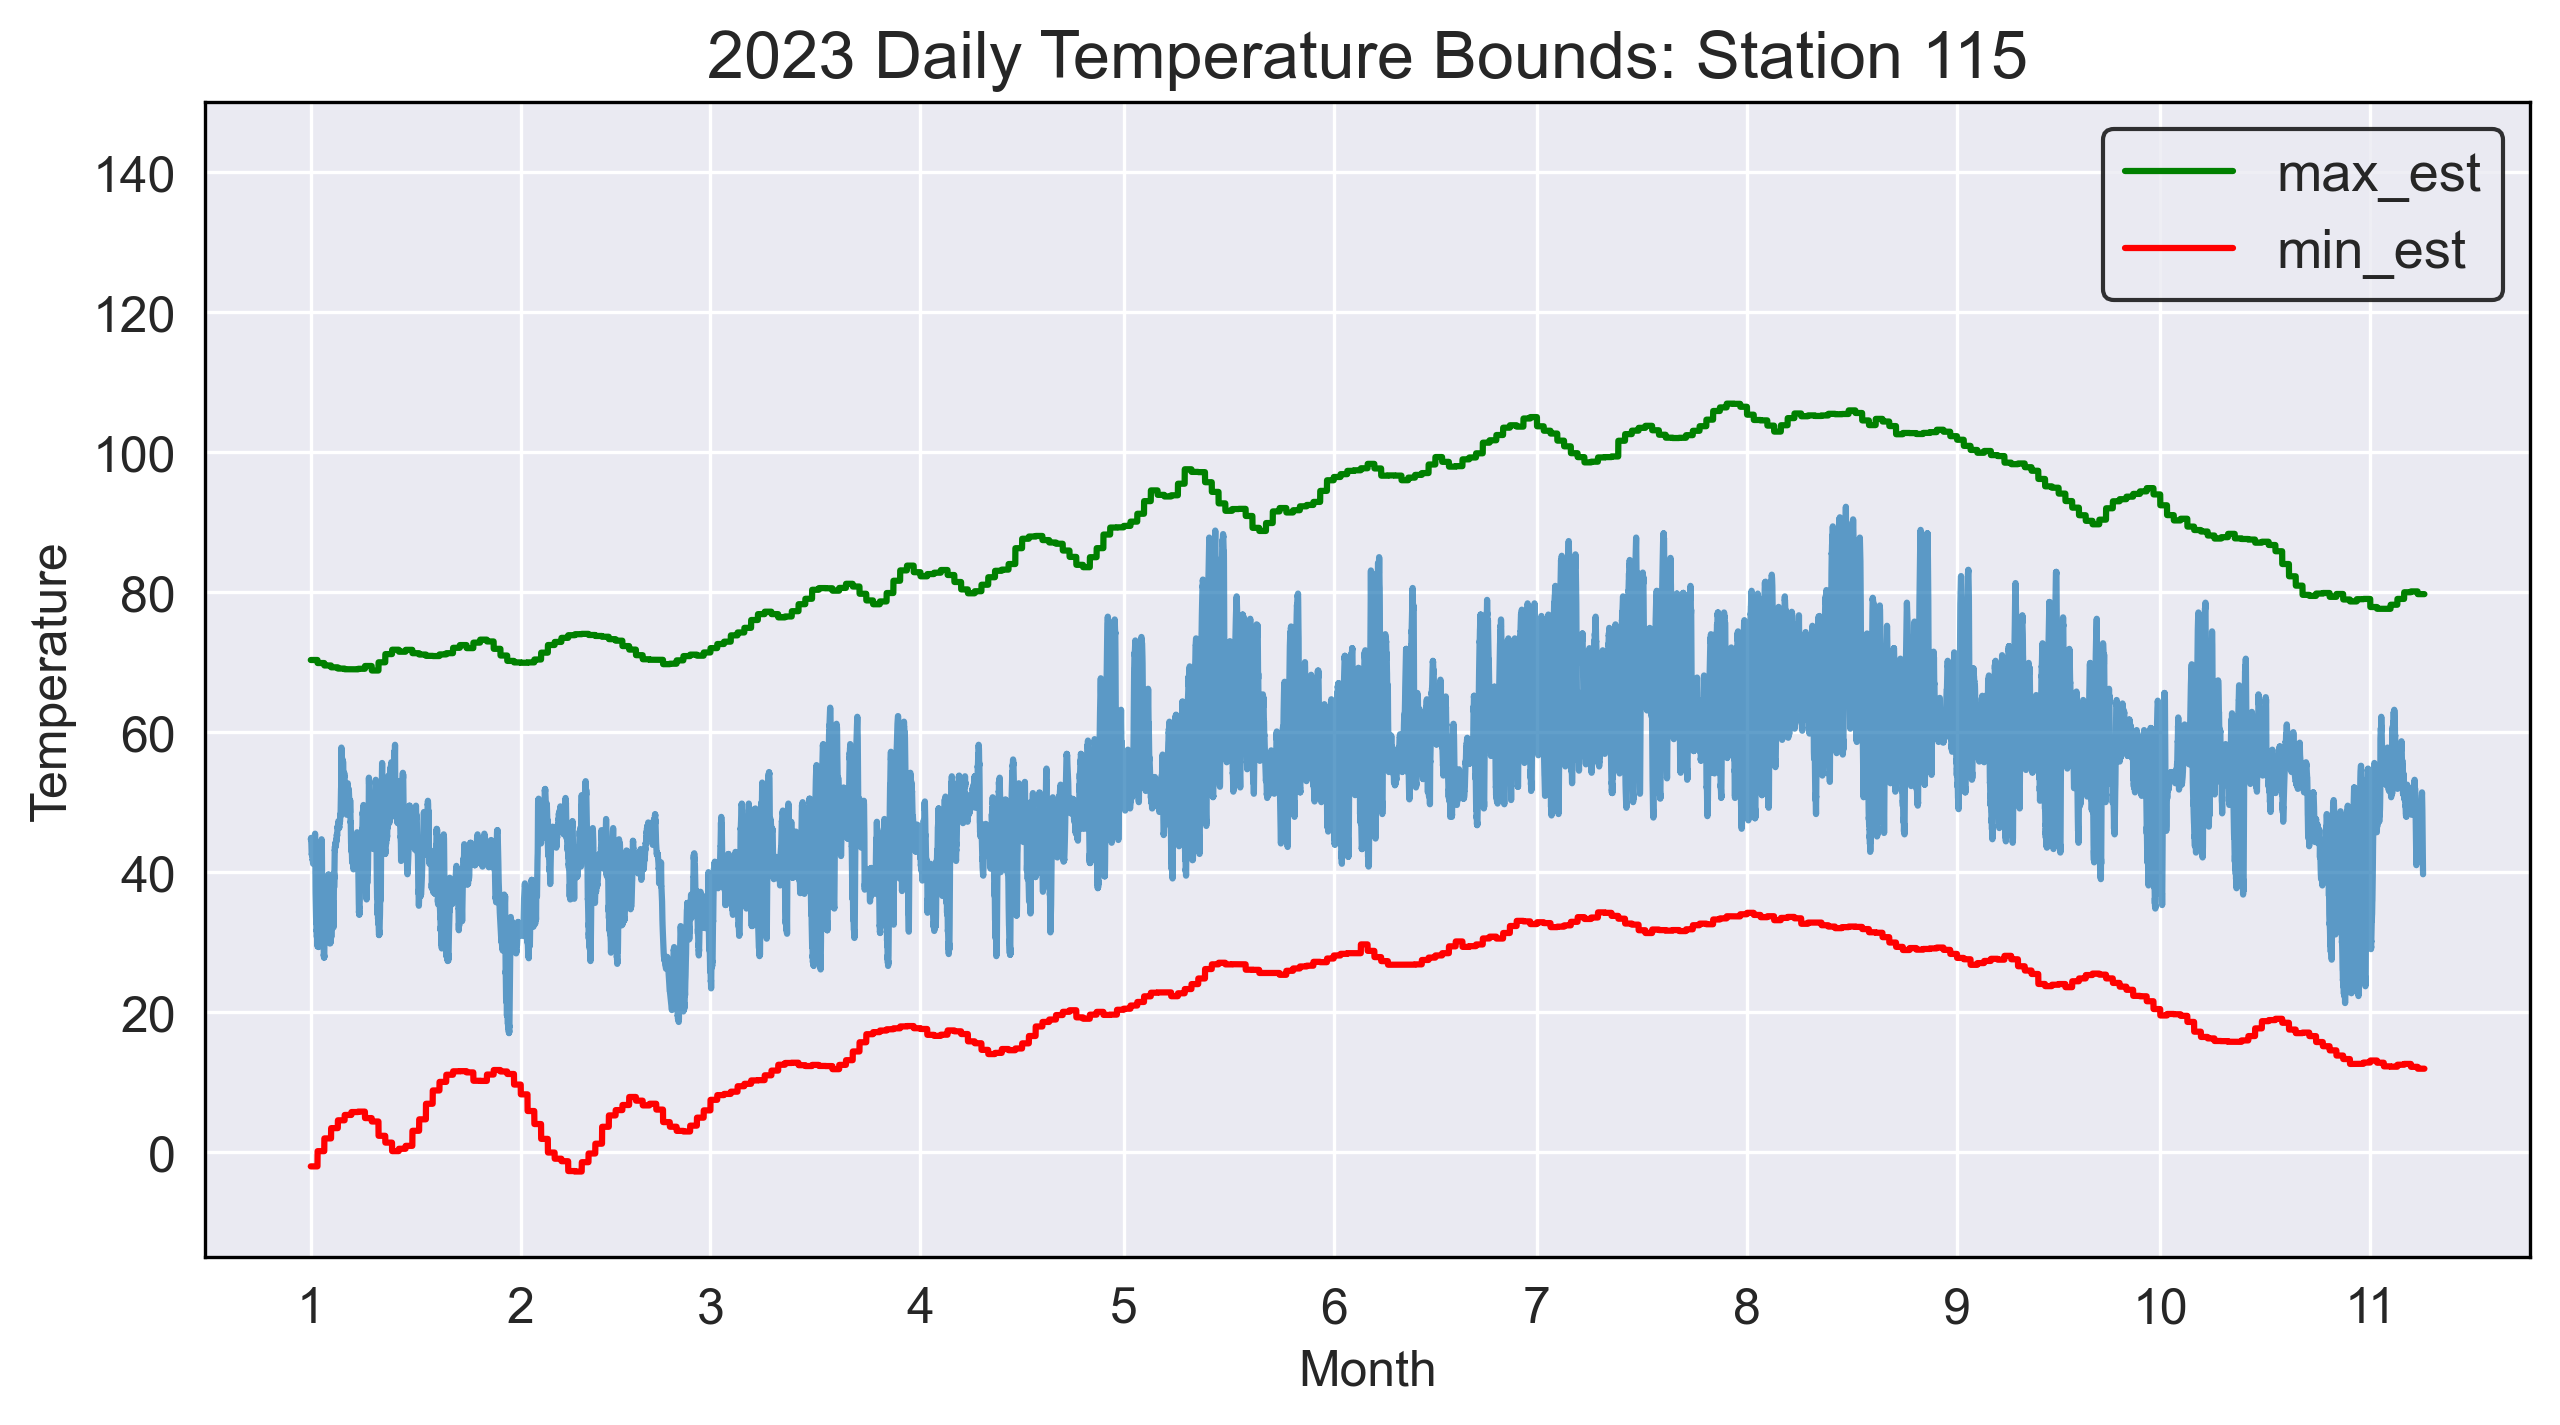

Flags Raised:
Too Hot: 0/29952 ; 0.0%
Too Cold: 0/29952 ; 0.0%
---------------------------------


In [8]:
for station in [115]:
    # Create pivot table for station
    s_pivot, years = create_pivot(station)

    # Split data (estimation and validation sets)
    s_pivot_e = s_pivot.iloc[:years[-1], :] # pull all data from start year - one before latest
    s_pivot_v = s_pivot.iloc[years[-1]:, :] # pull all data from latest - end

    # Get daily estimates of min/max
    #est = get_overall_bounds(s_pivot_e, 0.99, 15)

    # Generate graph + check how many values are marked as invalud
    #temp_val_graph(est, s_pivot_v, station)
    
    # Get daily estimates of min/max
    #est_new = temp_bounds_modified(s_pivot_e, 0.99, 15, 0.8)

    # Generate graph + check how many values are marked as invalud
    #temp_val_graph(est_new, s_pivot_v, str(station) + ' (QC Bounds)')
    
    # Get daily estimates of min/max (with filter applied)
    est_filter = temp_bounds_modified(s_pivot_e, 0.99, 15, 0.8, True)

    # Generate graph + check how many values are marked as invalud
    temp_val_graph(est_filter, s_pivot_v, str(station))

**Reasong for so many different methods**: 
- Station 115 had an issue where a single day had a large from around 60 degrees, down to -20, and back to 60 (with many missing values around the drop). This was not being caught by the quantile filter being applied at the daily level since the quantile value is so high (we could decrease, but this shrinks our bounds and causes more flags to be set). **Shown in first graph above.**
- As an initial fix, the same method applied to calculating temperature deltas was applied to temperature min/max (where we use a modified IQR method to filter out extreme outliers). The monthly estimate for min/max was acquire through this method, then the daily level was modified to be *daily_min = max(current daily min, monthly IQR min)* and *daily_max = min(current daily max, monthly IQR max)*. This did fix the issue. **Shown in second graph above.**
- However, another issue did occur. The plot for the daily min/max bounds seem to be very jagged and noisey. To reduce this, we can apply a filter in order to find a least squares line that fits through them all. By doing this, we can reduce the noise and find the new daily estimates that create a smoother bounding line. A [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter was applied, with a window size of 15 and degree 2 (no real intuition behind this, just what worked - this could be changed). By doing this, we get bounds that seem to fit the data much better and present the final solution. **Shown in the third graph.**

Below is the example of station 115 that led to change being needed to be made.

Credentials Loaded


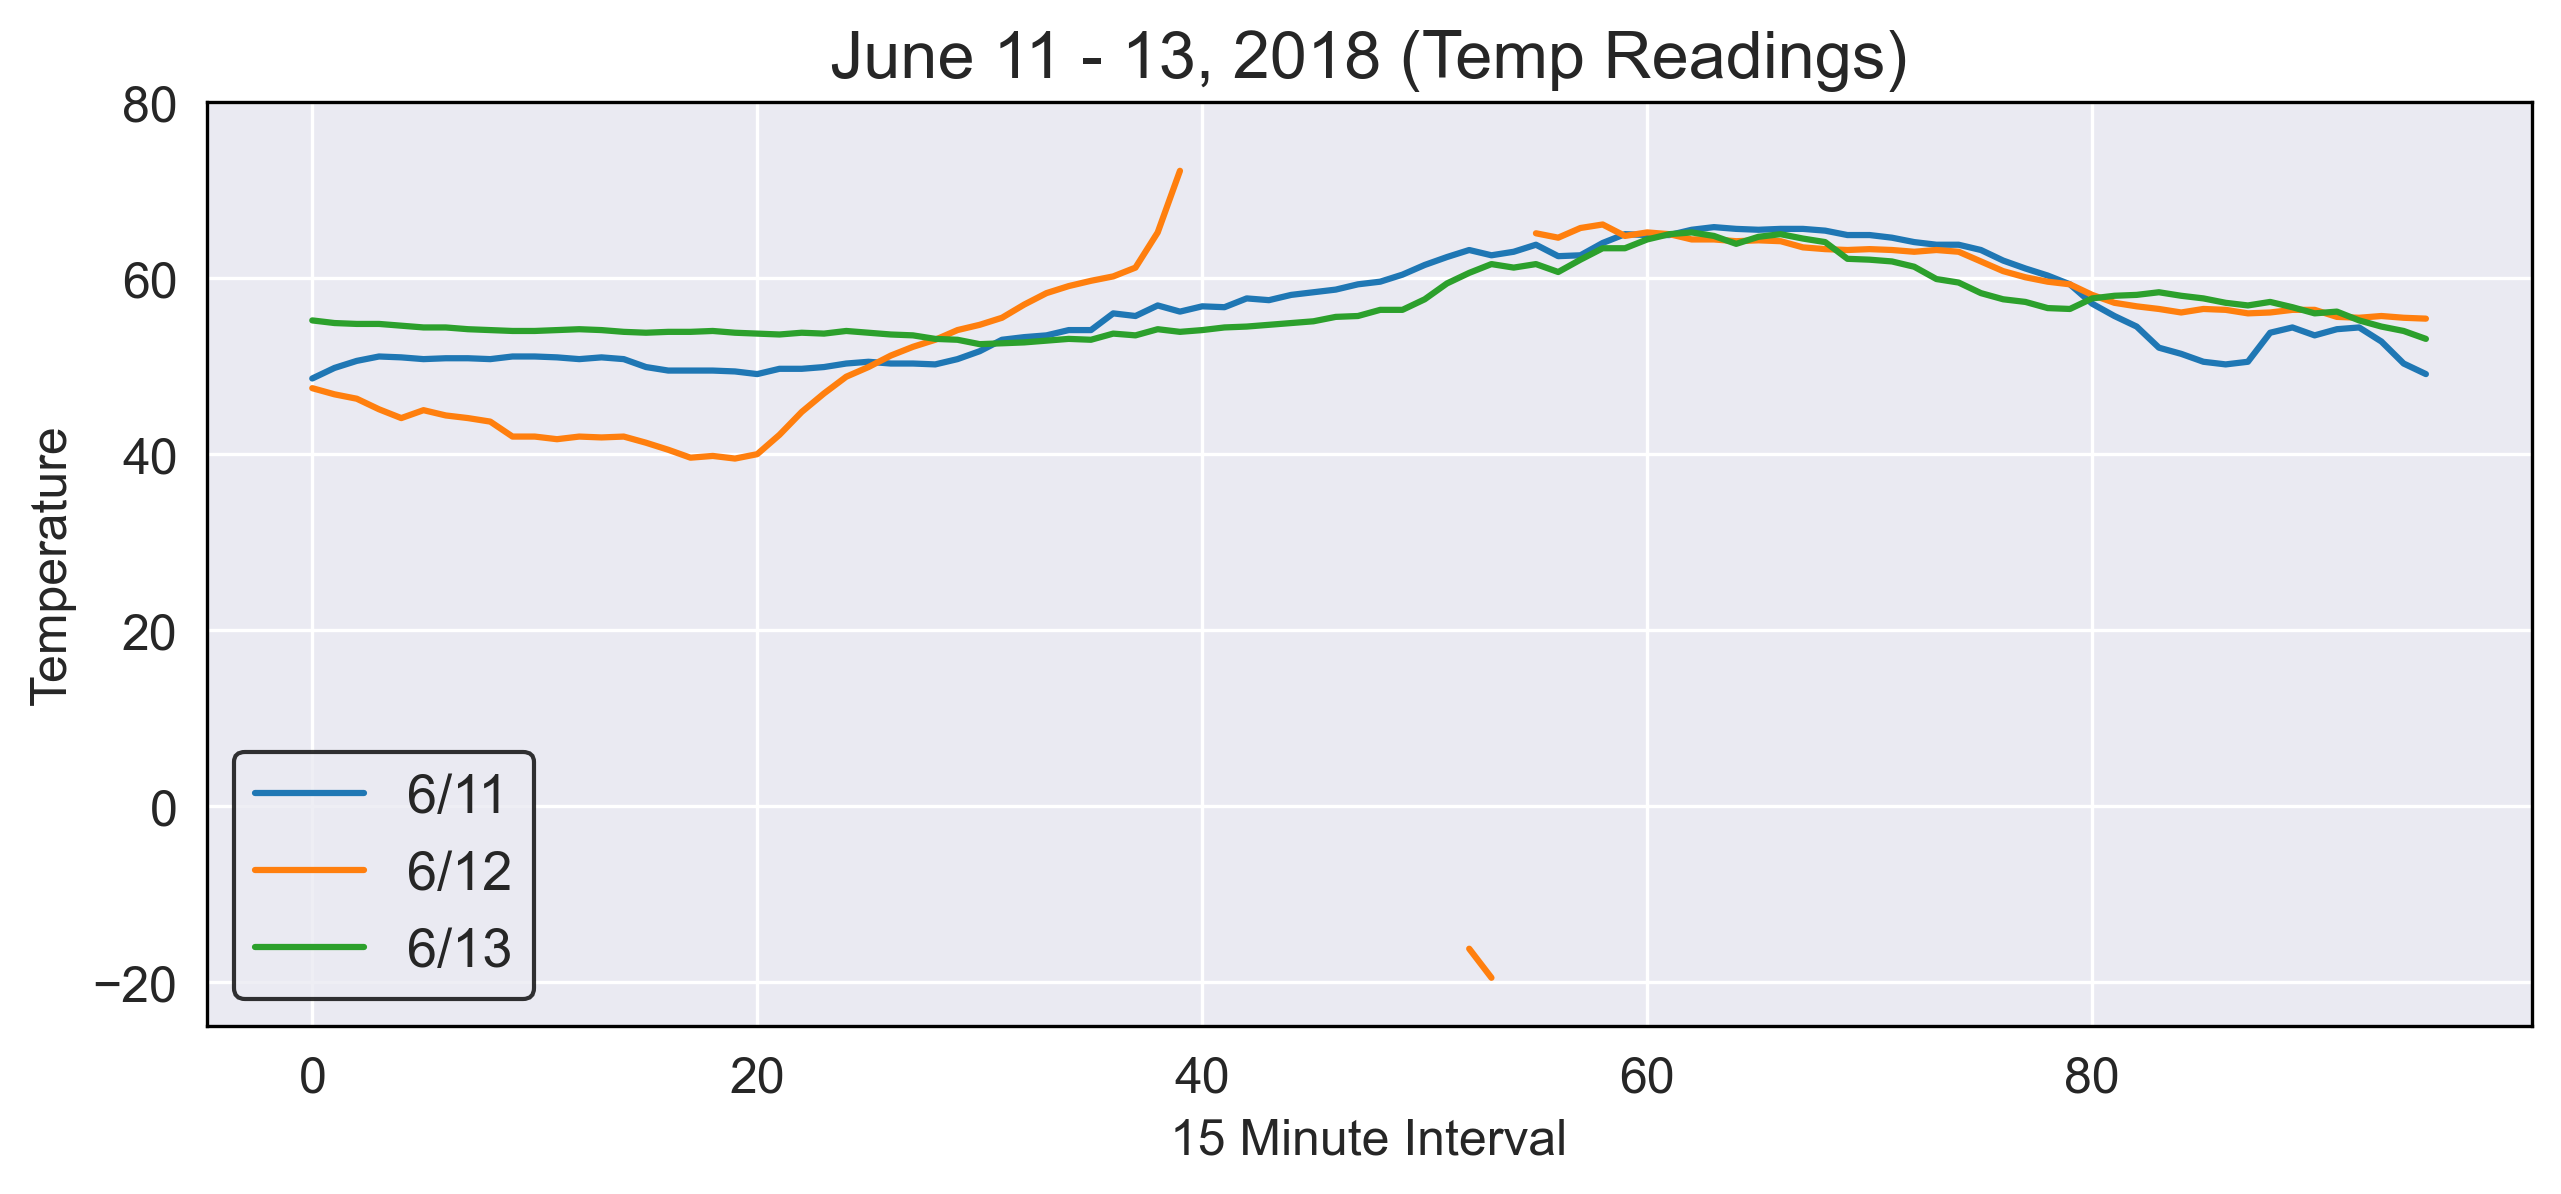

In [4]:
s_pivot, years = create_pivot(115)

june11 = s_pivot[s_pivot.index == '2018-06-11'].values.flatten()
june12 = s_pivot[s_pivot.index == '2018-06-12'].values.flatten()
june13 = s_pivot[s_pivot.index == '2018-06-13'].values.flatten()

plt.figure(figsize=(10,4))
plt.plot(june11, label ='6/11')
plt.plot(june12, label ='6/12')
plt.plot(june13, label ='6/13')
plt.title('June 11 - 13, 2018 (Temp Readings)')
plt.legend()
plt.xlabel('15 Minute Interval')
plt.ylabel('Temperature')
plt.ylim(-25, 80)
plt.show();

## Delta Temperature Bounds (Monthly)
The final method chosen for estimating the delta (per 15 minutes) is **monthly temperature deltas** based on the following:
- For all temperature readings, take the difference between the current, and the previous, in order to find the delta for each 15 minute interval.
- For each month, take data across all years in the evaluation data set as a subset of the original data.
- Use quantiles to take the upper and lower quantile, specified by user, to encapsulate the middle *q_val* percent of the data.
- We then calculate the iqr between these values, and find the min/max bounds by taking the upper quantile and adding 1.5\*iqr (and similarly, taking the lower quantile and subtracting 1.5\*iqr to it). A threshold is added on to this (specified by the user) to allow for some variance in the delta's bounds.

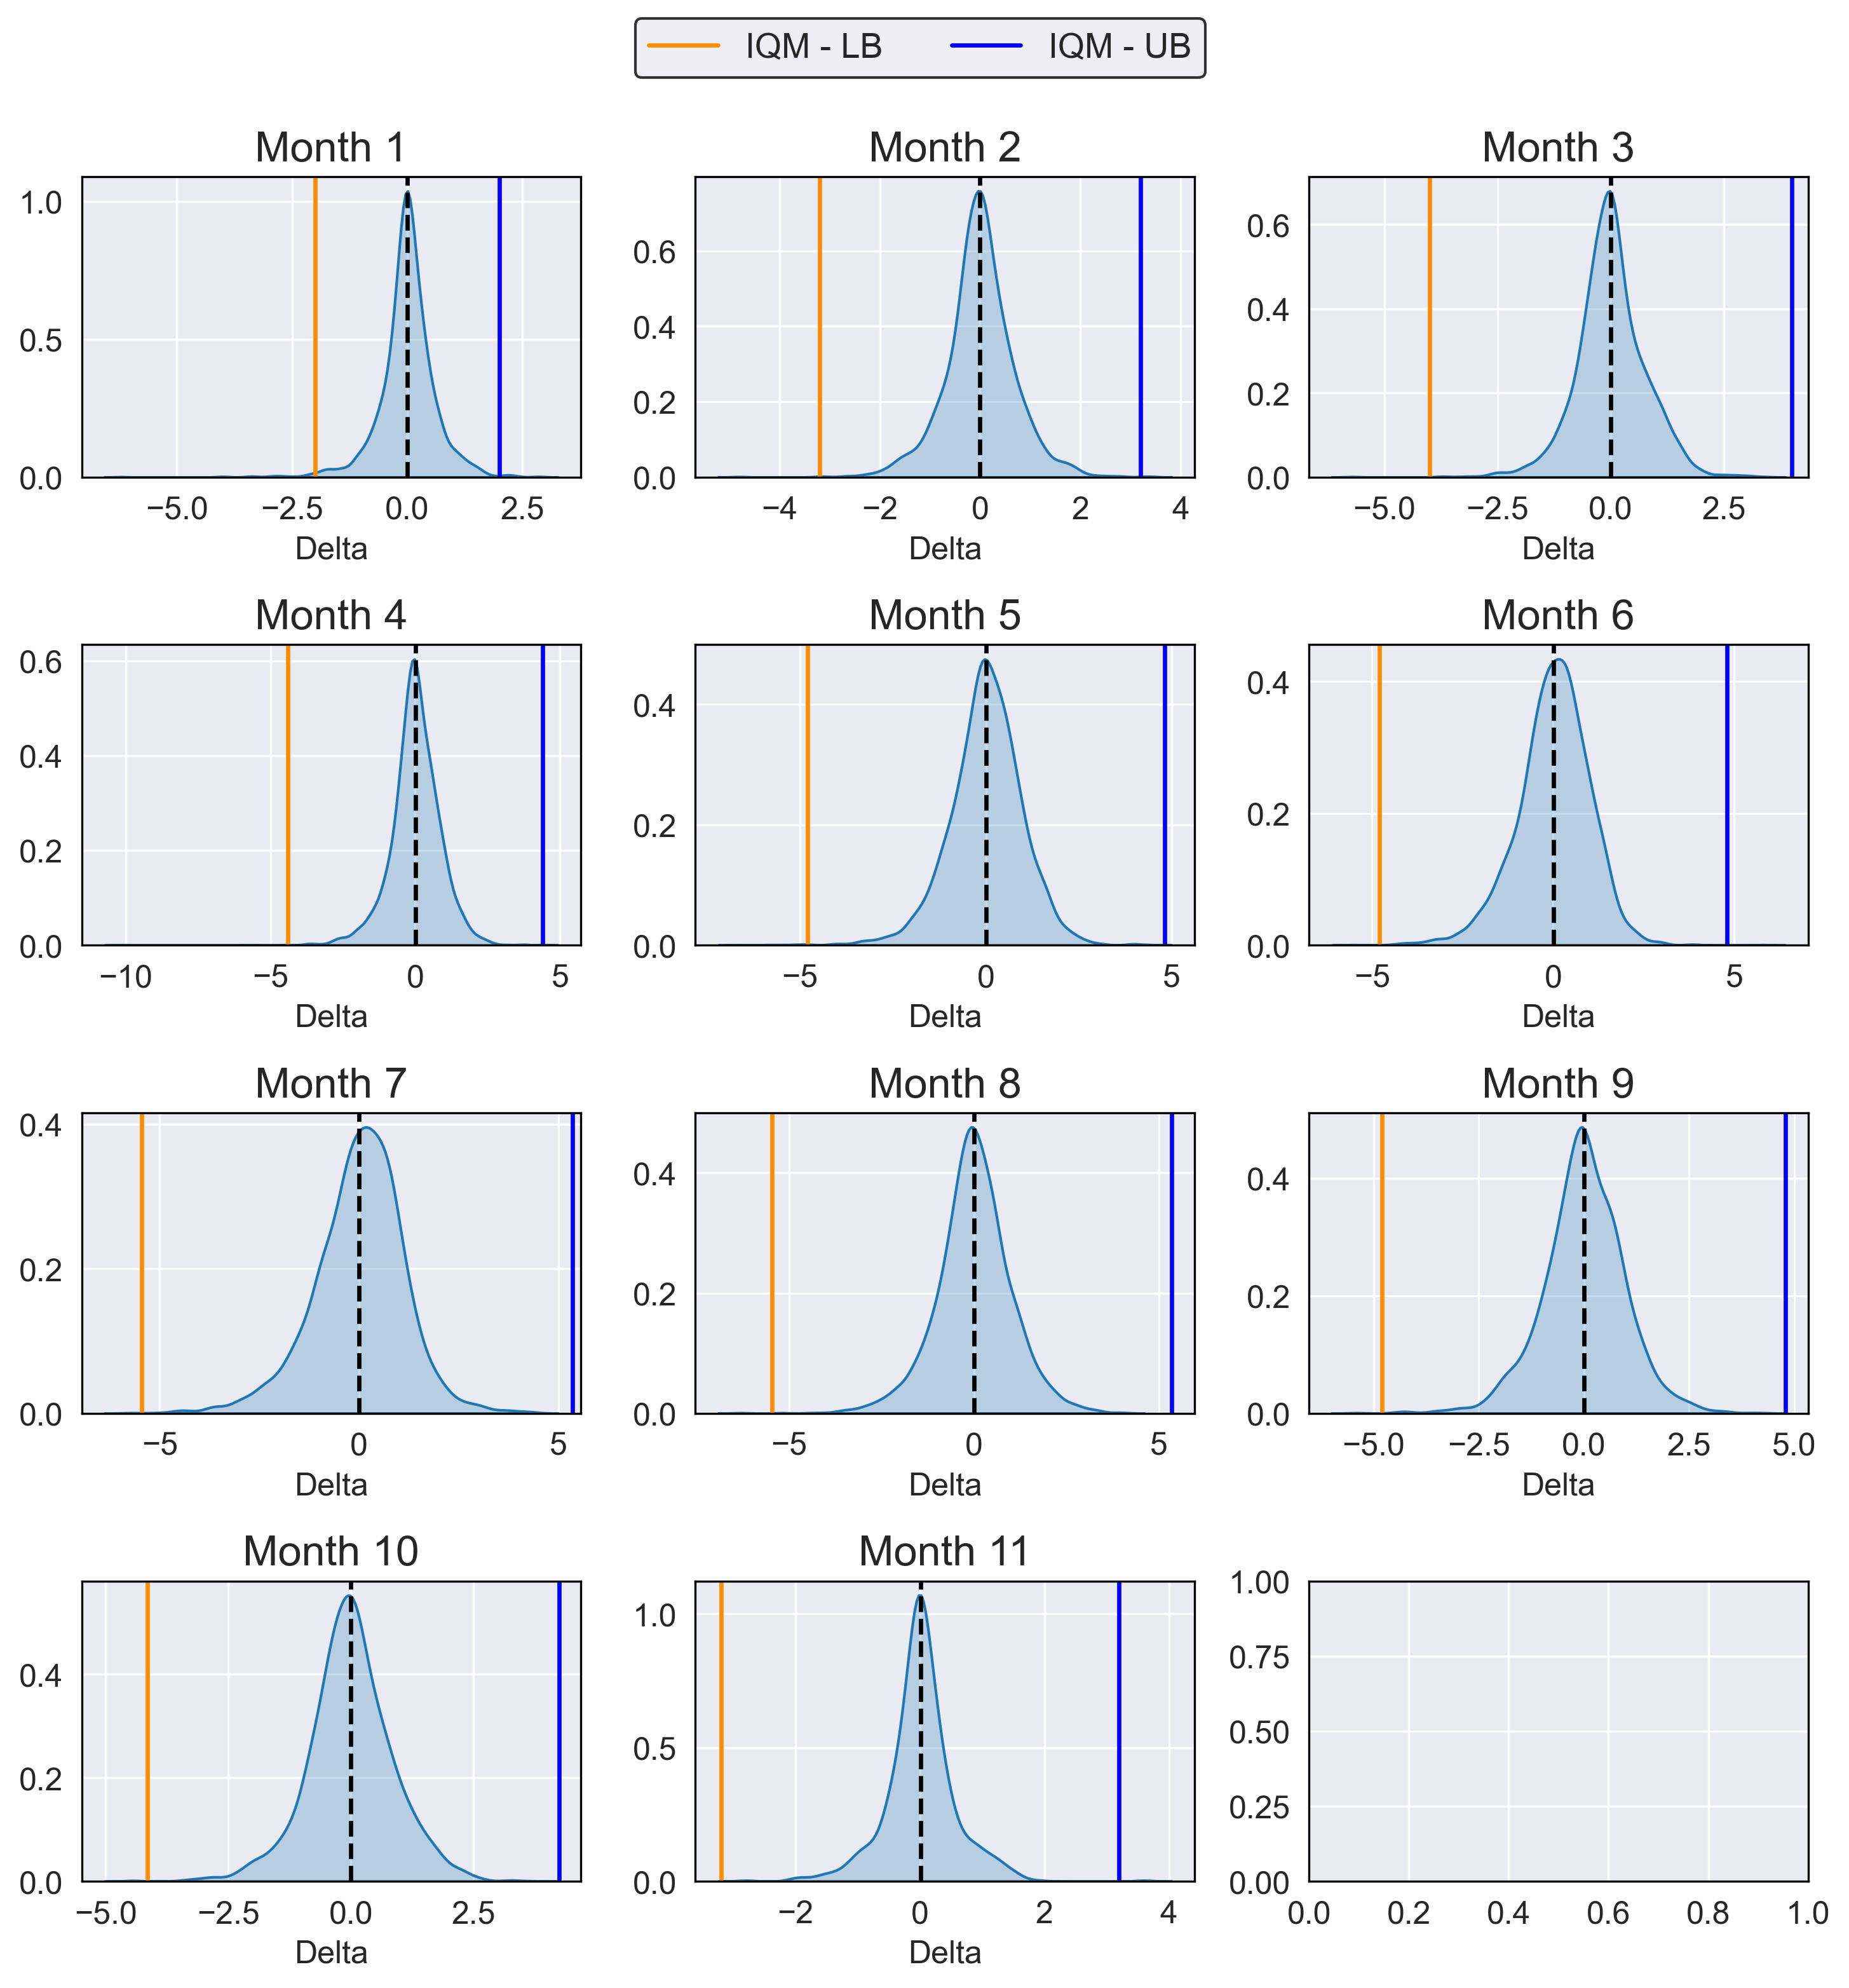

In [3]:
for station in [118]:
    # Create pivot table for station
    s_pivot, years = create_pivot(station)

    # Split data (estimation and validation sets)
    s_pivot_e = s_pivot.iloc[:years[-1], :] # pull all data from start year - one before latest
    s_pivot_v = s_pivot.iloc[years[-1]:, :] # pull all data from latest - end

    # Get daily estimates of delta
    est = get_delta_est(s_pivot_e, 0.9, 0)
    
    # Plot monthly delta with bounds
    plot_monthly_delta(s_pivot_v, est)

In [26]:
delta_flag_table(s_pivot_v, est)

In [2]:
multi_s = pd.DataFrame()

for station in [115]: #, 36, 63, 118,  64]:
    # Create pivot table for station
    s_pivot, years = create_pivot(station)

    # Split data (estimation and validation sets)
    s_pivot = s_pivot.iloc[:years[-1], :] # pull all data from start year - one before latest
    s_pivot['station'] = station
    
    multi_s = pd.concat([multi_s, s_pivot])

# 115 top left
# 36 bottom right
# 63 bottom left/middle
# 118 middle right

In [3]:
def plot_monthly_delta_multi(data):
    '''
    Create 12 subplots, one for each month, that show the delta across 15 minute intervals.
    Lower and upper bounds are plotted as horizontal bars, with the delta's being presented
    as a density plot.
    '''
    s_tmp = data.copy() # create copy (don't alter original)

    s_tmp['month'] = [int(x.split('-')[1]) for x in s_tmp.index.values] # create month column

    months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    stations = ['115 (NW)', '36 (SE)', '63 (SW)', '118 (CN)', '64']

    # Create dataframe of min and max values, each row is different station
    min_df = pd.DataFrame(np.nan, index=stations, columns=months)
    max_df = pd.DataFrame(np.nan, index=stations, columns=months)

    for i, s in enumerate(s_tmp.station.unique()):
        single = s_tmp[s_tmp.station == s] # subset single station

        m_d_low = []
        m_d_high = []

        for m in s_tmp.month.unique(): # iterate over each month
            tmp = single[single.month == m] # subset single month
            tmp = tmp.drop(columns=['month', 'station']) # drop column
            vals = np.diff(tmp.values.flatten())
            m_d_low.append(round(np.nanquantile(vals, 0.005), 1))
            m_d_high.append(round(np.nanquantile(vals, 0.995), 1))

        # Append min and max deltas
        min_df.iloc[i] = m_d_low
        max_df.iloc[i] = m_d_high
     
    # Create range dataframes (difference and string)
    range_df = max_df - min_df
    str_df = min_df.astype(str) + ', ' + max_df.astype(str)

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
    spectral_cmap = plt.cm.get_cmap('Spectral')
    spectral_reversed = spectral_cmap.reversed()

    # Plot heatmaps
    sns.heatmap(max_df, ax=axes[0], cmap=ListedColormap(['white']), annot=str_df.values, fmt="", 
                linewidths=0.5, linecolor='black', cbar=False)
    axes[0].set_title('Delta [Min, Max] Per Month', fontsize=14)
    axes[0].yaxis.set_tick_params(rotation=0)
    axes[0].set_ylabel('Station (+ Position)')

    sns.heatmap(range_df, ax=axes[1], cmap=spectral_reversed, annot=True, linewidths=0.5, linecolor='black')
    axes[1].set_title('Delta Range Per Month', fontsize=14)
    axes[1].yaxis.set_tick_params(rotation=0)
    axes[1].set_ylabel('Station (+ Position)')


    plt.tight_layout()
    plt.show()
    
    return

In [4]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def plot(x, z_t):
    plt.figure(figsize=(10,6))
    
    sns.distplot(x, rug=True, hist=False)
    mbo = mad_based_outlier(x, z_t)
    outliers = x[mbo]
    valid = x[np.invert(mbo)]
    plt.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)
    plt.vlines(max(valid), 0, 0.9, colors = 'green', linewidth=3, label=f'Max: {round(max(valid), 3)}')
    plt.vlines(min(valid), 0, 0.9, colors = 'orange', linewidth=3, label=f'Min: {round(min(valid), 3)}')
    
    plt.legend()
    
    return


In [30]:
tmp = multi_s.iloc[:31]
tmp.drop(columns=['station'], inplace=True)

y = np.diff(tmp.values.flatten())
t = y[~np.isnan(y)]

In [20]:
for c, i in enumerate(range(0, len(t), 40)):
    if c % 2 == 0:
        t[i] += 10
    else:
        t[i] -= 10

In [29]:
v = pd.Series(t).rolling(2).mean().values

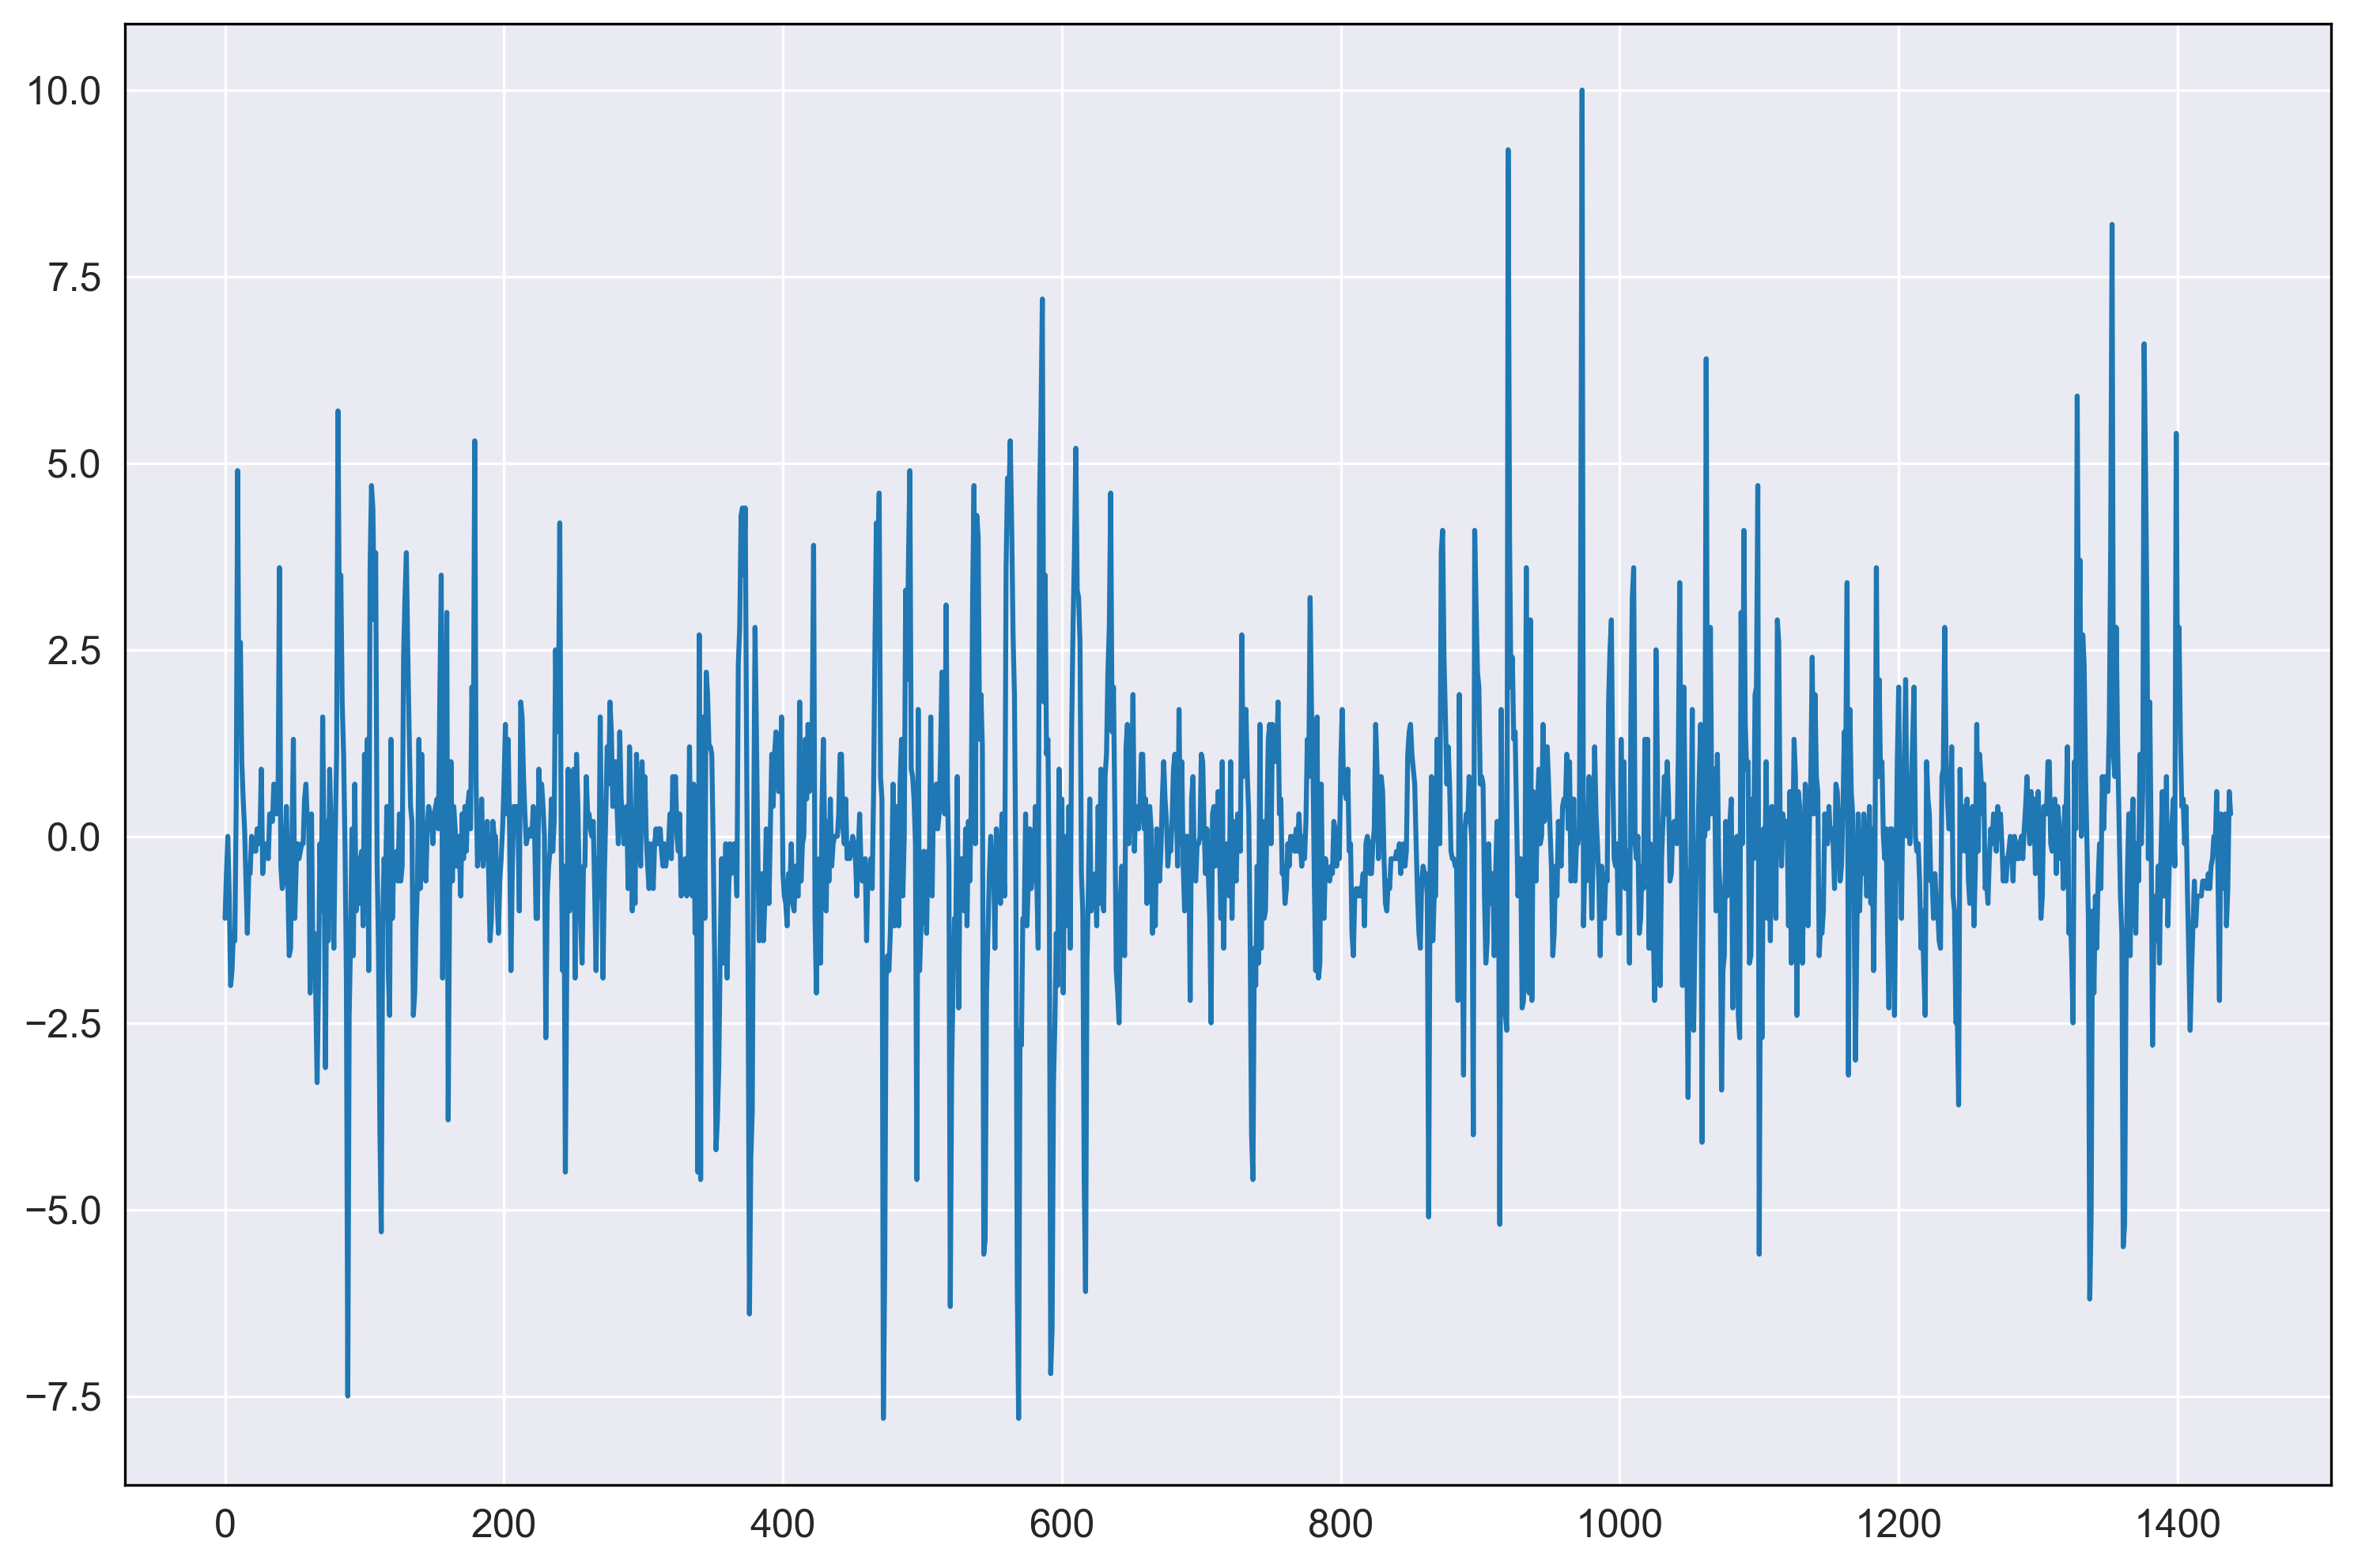

In [37]:
plt.figure(figsize=(12,8))
plt.plot(t)
#plt.plot(v)
plt.show()

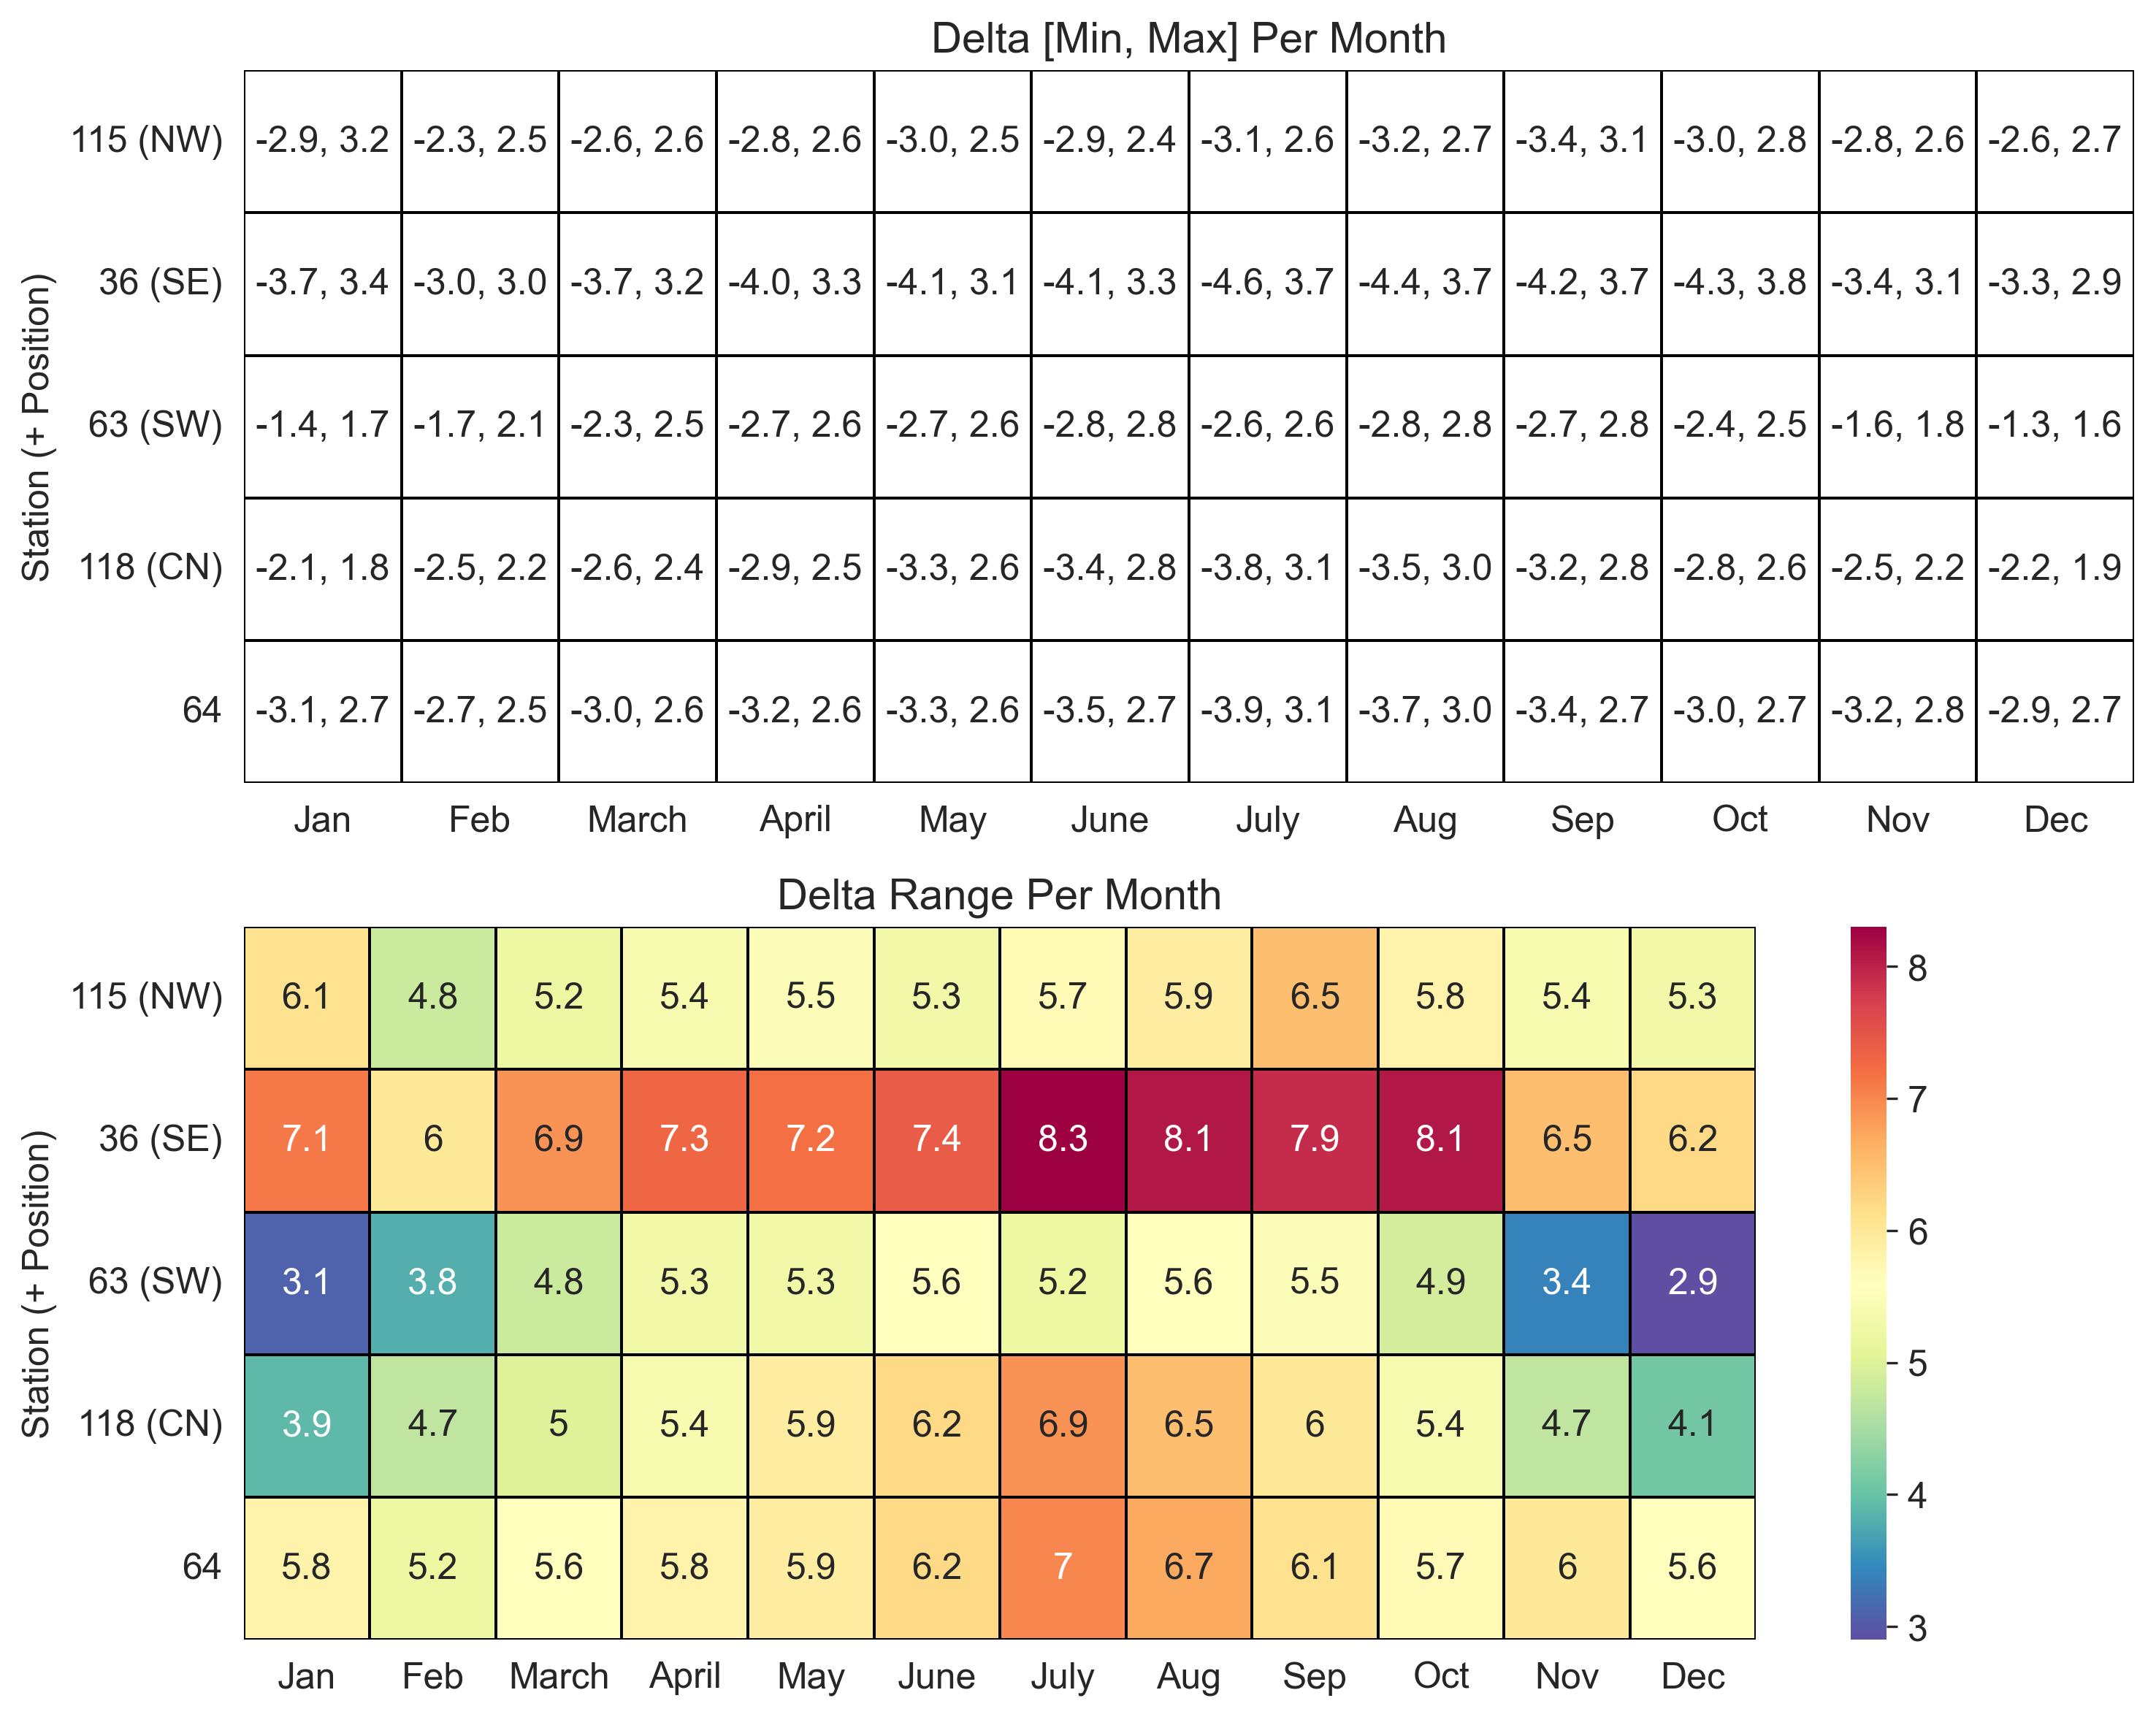

In [12]:
# Plot all data (from 2014-2023) per month, for all stations in data frame
plot_monthly_delta_multi(multi_s)

In [23]:
est.T

Month,01,02,03,04,05,06,07,08,09,10,11,12
iq_lb,-3.2,-3.2,-4.0,-4.0,-4.4,-4.65,-5.3,-5.3,-4.65,-4.4,-3.6,-2.8
iq_ub,3.2,3.2,4.0,4.0,4.4,4.55,5.1,5.1,4.55,4.4,3.6,2.8
